In [2]:
import tensorflow as tf
print(tf.__version__)

2.14.0


In [3]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-876d9727-bf1e-31b5-4373-72ef9b5ee54d)


In [4]:
# Get helper functions file
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py


--2023-11-13 19:12:57--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-11-13 19:12:57 (54.1 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [5]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys


In [6]:

# Get TensorFlow Datasets
import tensorflow_datasets as tfds


datasets_list = tfds.list_builders() # get all available datasets in TFDS
print("food101" in datasets_list) # is the dataset we're after available?


True


In [8]:
(train_data, test_data), ds_info = tfds.load(name='food101',
                                             split=['train', 'validation'],
                                             shuffle_files=True,
                                             as_supervised=True, # data get returned in tupple form (data, label))
                                             with_info=True,

)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/75750 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incomplete9Y06LL/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incomplete9Y06LL/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


# Features of Food101 from TFDS

In [9]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [10]:
# Get the class names
class_names = ds_info.features['label'].names
class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

## Exploring the food101 data from tensorflow datasets

Let's find out a few details about our dataset:

* The shape of our input data (image tensors)
* The datatype of our input data
* What the labels of our input data look like (e.g. one-hot encoded versus
label-encoded)
* Do the labels match up with the class names?

In [11]:
# Take one sample of the train data
train_one_sample = train_data.take(1)
train_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [17]:
# Output info about our training sample
for image, label in train_one_sample:
  print(f"""
  Image shape: {image.shape}
  Image data type: {image.dtype}
  Target class from FOOD101 (tensor form): {label.numpy()}
  Class name (str form): {class_names[label.numpy()]}

  """)


  Image shape: (512, 512, 3)
  Image data type: <dtype: 'uint8'>
  Target class from FOOD101 (tensor form): 75
  Class name (str form): pho

  


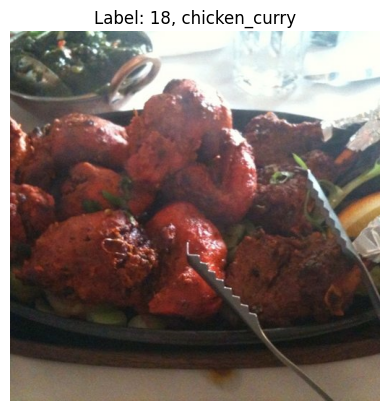

In [16]:
## Plot an image from dataset
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

for image, label in train_one_sample:

  # Plot the image
  plt.imshow(image)
  plt.axis(False)

  if label is not None:
    plt.title(f"Label: {label}, {class_names[label.numpy()]}")

In [57]:
image

<tf.Tensor: shape=(512, 512, 3), dtype=uint8, numpy=
array([[[ 48,  51,  30],
        [ 49,  52,  31],
        [ 50,  55,  33],
        ...,
        [ 93, 120,  77],
        [ 87, 112,  70],
        [ 80, 105,  63]],

       [[ 43,  46,  25],
        [ 46,  49,  28],
        [ 49,  54,  32],
        ...,
        [ 95, 122,  77],
        [ 90, 117,  72],
        [ 83, 110,  65]],

       [[ 40,  43,  22],
        [ 45,  48,  27],
        [ 50,  55,  33],
        ...,
        [ 90, 119,  71],
        [ 87, 116,  68],
        [ 84, 113,  65]],

       ...,

       [[ 48,  55,  37],
        [ 48,  55,  37],
        [ 41,  50,  33],
        ...,
        [ 32,  43,  35],
        [ 25,  36,  30],
        [ 21,  32,  26]],

       [[ 42,  47,  27],
        [ 38,  46,  25],
        [ 34,  43,  26],
        ...,
        [ 38,  49,  41],
        [ 33,  44,  38],
        [ 29,  40,  34]],

       [[ 37,  42,  20],
        [ 32,  40,  19],
        [ 31,  38,  20],
        ...,
        [ 33,  44,  3

## Create preprocessing function for our data

In [15]:
# Make a function for preprocessing images
def preprocess_img(image, label, img_shape=224):
  """
  Converts Image datatype from uint8 to float32 and
  reshapes image to [img_shape,img_shape,color_channels]
  """

  image = tf.image.resize(image, [img_shape, img_shape])
  return tf.cast(image, tf.float32), label # return a tuple


In [27]:
# Preprocess a single sample image and check the outputs
preprocessed_img = preprocess_img(image, label)[0]
preprocessed_img.shape, preprocessed_img.dtype

(TensorShape([224, 224, 3]), tf.float32)

## Batch and prepare dataset

In [28]:

# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# Map prepreprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)
# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

In [12]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>)

##  Create Modelling Callbacks

In [29]:
# Create model checkpoint
checkpoint_path = 'model_checkpoints/cp.ckpt'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_acc',
    save_best_only=True,
    save_weights_only=True,
    verbose=0
)

## Setup mixed precision training

In [30]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import mixed_precision



In [31]:
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)

## Build feature extraction model

In [32]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create base model
input_shape = (224,224,3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

# Create functional model
inputs = layers.Input(shape=input_shape, name='input_layer')
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(len(class_names))(x)
outputs = layers.Activation("softmax", dtype=tf.float32, name='softmax_float32')(x)

model = tf.keras.Model(inputs, outputs)


# Compile model
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
)

16705208/16705208 [==============================] - 2s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                             

In [ ]:
for layer in model.layers:
    layer_name = layer.name
    layer_dtype = layer.dtype
    layer_dtype_policy = layer.dtype_policy
    print(f"Layer Name: {layer_name}, Data Type: {layer_dtype}, Policy {layer_dtype_policy}")


Layer Name: input_layer, Data Type: float32, Policy <Policy "float32">
Layer Name: efficientnetb0, Data Type: float32, Policy <Policy "mixed_float16">
Layer Name: global_average_pooling2d, Data Type: float32, Policy <Policy "mixed_float16">
Layer Name: dense, Data Type: float32, Policy <Policy "mixed_float16">
Layer Name: softmax_float32, Data Type: float32, Policy <Policy "float32">


In [ ]:
history_101_food_classes_feature_extraction = model.fit(
    train_data,
    epochs=3,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=int(0.15 * len(test_data)),
    callbacks=[model_checkpoint]
)

Epoch 1/3
2368/2368 [==============================] - ETA: 0s - loss: 1.7184 - accuracy: 0.5825

2368/2368 [==============================] - 282s 109ms/step - loss: 1.7184 - accuracy: 0.5825 - val_loss: 1.1303 - val_accuracy: 0.6981
Epoch 2/3
2367/2368 [============================>.] - ETA: 0s - loss: 1.2022 - accuracy: 0.6875

2368/2368 [==============================] - 204s 85ms/step - loss: 1.2023 - accuracy: 0.6875 - val_loss: 1.0338 - val_accuracy: 0.7201
Epoch 3/3
2368/2368 [==============================] - ETA: 0s - loss: 1.0553 - accuracy: 0.7239

2368/2368 [==============================] - 203s 84ms/step - loss: 1.0553 - accuracy: 0.7239 - val_loss: 0.9899 - val_accuracy: 0.7262


In [ ]:
# Evaluate model on whole test dataset
results_feature_extract_moddel = model.evaluate(test_data)


790/790 [==============================] - 56s 71ms/step - loss: 0.9964 - accuracy: 0.7274


In [ ]:
history_101_food_classes_feature_extraction

## TODO: Save the whole model to file

In [ ]:
model.save("/content/drive/MyDrive/TF Models/101_food_all_classes_feature_extractor")

In [18]:
# Load model previously saved
loaded_model = tf.keras.models.load_model("/content/drive/MyDrive/TF Models/101_food_all_classes_feature_extractor")

In [19]:
# Check layers
for layer in loaded_model.layers:
    layer_name = layer.name
    layer_dtype = layer.dtype
    layer_dtype_policy = layer.dtype_policy
    print(f"Layer Name: {layer_name}, Data Type: {layer_dtype}, Policy {layer_dtype_policy}")


Layer Name: input_layer, Data Type: float32, Policy <Policy "float32">
Layer Name: efficientnetb0, Data Type: float32, Policy <Policy "mixed_float16">
Layer Name: global_average_pooling2d, Data Type: float32, Policy <Policy "mixed_float16">
Layer Name: dense, Data Type: float32, Policy <Policy "mixed_float16">
Layer Name: softmax_float32, Data Type: float32, Policy <Policy "float32">


In [20]:
# Check loaded model performance (this should be the same as results_feature_extract_model)

results_loaded_model = loaded_model.evaluate(test_data)


ValueError: ignored

In [ ]:
results_loaded_model[1] == results_feature_extract_moddel[1]

In [21]:
# Download the saved model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip


--2023-11-13 19:29:56--  https://storage.googleapis.com/ztm_tf_course/food_vision/07_efficientnetb0_feature_extract_model_mixed_precision.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.10.207, 142.251.12.207, 172.217.194.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.10.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16976857 (16M) [application/zip]
Saving to: ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip’

07_efficientnetb0_f 100%[===================>]  16.19M  8.72MB/s    in 1.9s    

2023-11-13 19:29:59 (8.72 MB/s) - ‘07_efficientnetb0_feature_extract_model_mixed_precision.zip’ saved [16976857/16976857]



In [22]:
# Unzip the SavedModel downloaded from Google Stroage
!mkdir downloaded_gs_model # create new dir to store downloaded feature extraction model
!unzip 07_efficientnetb0_feature_extract_model_mixed_precision.zip -d downloaded_gs_model


Archive:  07_efficientnetb0_feature_extract_model_mixed_precision.zip
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/variables.data-00000-of-00001  
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/variables/variables.index  
  inflating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/saved_model.pb  
   creating: downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision/assets/


In [23]:
gl_model = tf.keras.models.load_model('/content/downloaded_gs_model/07_efficientnetb0_feature_extract_model_mixed_precision')

In [24]:
# Get a summary of the downloaded model
gl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 pooling_layer (GlobalAvera  (None, 1280)              0         
 gePooling2D)                                                    
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                             

In [33]:
# How does the loaded model perform? (evaluate it on the test dataset)
daniel_model_results = gl_model.evaluate(test_data)
daniel_model_results

790/790 [==============================] - 67s 70ms/step - loss: 1.0881 - accuracy: 0.7066


[1.0880995988845825, 0.7066138386726379]

In [34]:
# Set all of the layers .trainable variable in the loaded model to True (so they're unfrozen)
gl_model.trainable = True
# Check the layers in the base model and see what dtype policy they're using
for layer in gl_model.layers[1].layers[:20]:
  print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)



input_1 True float32 <Policy "float32">
rescaling True float32 <Policy "mixed_float16">
normalization True float32 <Policy "float32">
stem_conv_pad True float32 <Policy "mixed_float16">
stem_conv True float32 <Policy "mixed_float16">
stem_bn True float32 <Policy "mixed_float16">
stem_activation True float32 <Policy "mixed_float16">
block1a_dwconv True float32 <Policy "mixed_float16">
block1a_bn True float32 <Policy "mixed_float16">
block1a_activation True float32 <Policy "mixed_float16">
block1a_se_squeeze True float32 <Policy "mixed_float16">
block1a_se_reshape True float32 <Policy "mixed_float16">
block1a_se_reduce True float32 <Policy "mixed_float16">
block1a_se_expand True float32 <Policy "mixed_float16">
block1a_se_excite True float32 <Policy "mixed_float16">
block1a_project_conv True float32 <Policy "mixed_float16">
block1a_project_bn True float32 <Policy "mixed_float16">
block2a_expand_conv True float32 <Policy "mixed_float16">
block2a_expand_bn True float32 <Policy "mixed_float

In [35]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 3 epochs
# Monitor the val_loss and stop training if it doesn't improve for 3 epochs
# See: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping for more
# YOUR_CODE_HERE

earlystopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0
)


# Create ModelCheckpoint callback to save best model during fine-tuning
# Save the best model only
# Monitor val_loss while training and save the best model (lowest val_loss)
# See: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint for more
# YOUR_CODE_HERE
# Create model checkpoint
checkpoint_path = 'daniel_model_checkpoints/cp.ckpt'
daniel_model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    verbose=0
)


In [36]:
# Compile the model ready for fine-tuning
# Use the Adam optimizer with a 10x lower than default learning rate
# YOUR_CODE_HERE

# Recompile model with lower learning rate
gl_model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4), # 10x lower learning rate than default
              metrics=['accuracy'])


In [37]:
# Start to fine-tune (all layers)
# Use 100 epochs as the default
# Validate on 15% of the test_data
# Use the create_tensorboard_callback, ModelCheckpoint and EarlyStopping callbacks you created eaelier
# YOUR_CODE_HERE

history_101_food_classes_all_data_fine_tune = gl_model.fit(
    train_data,
    epochs=50,
    steps_per_epoch=len(train_data),
    validation_data=test_data,
    validation_steps=int(0.15 * len(test_data)),
    callbacks=[daniel_model_checkpoint, earlystopping_callback]
)


Epoch 1/50
2368/2368 [==============================] - 426s 159ms/step - loss: 0.9221 - accuracy: 0.7524 - val_loss: 0.7909 - val_accuracy: 0.7794
Epoch 2/50
2368/2368 [==============================] - 378s 158ms/step - loss: 0.5781 - accuracy: 0.8395 - val_loss: 0.7878 - val_accuracy: 0.7865
Epoch 3/50
2368/2368 [==============================] - 381s 159ms/step - loss: 0.3298 - accuracy: 0.9054 - val_loss: 0.8787 - val_accuracy: 0.7892
Epoch 4/50
2368/2368 [==============================] - 383s 160ms/step - loss: 0.1747 - accuracy: 0.9478 - val_loss: 0.9820 - val_accuracy: 0.7770
Epoch 5/50
2368/2368 [==============================] - 375s 157ms/step - loss: 0.1088 - accuracy: 0.9666 - val_loss: 1.0495 - val_accuracy: 0.7791


In [38]:
# Save model locally (note: if you're using Google Colab and you save your model locally, it will be deleted when your Google Colab session ends)


In [39]:
gl_model.save("/content/drive/MyDrive/TF Models/gl_model_101_food_all_classes_feature_extractor")

In [40]:
# Evaluate mixed precision trained fine-tuned model (this should beat DeepFood's 77.4% top-1 accuracy)
results_gl_model = gl_model.evaluate(test_data)
results_gl_model

790/790 [==============================] - 57s 72ms/step - loss: 1.0666 - accuracy: 0.7753


[1.0665661096572876, 0.7753267288208008]

## TODO: Evaluate your trained model

In [41]:
pred_probs = gl_model.predict(test_data)
pred_probs


790/790 [==============================] - 56s 69ms/step


array([[1.45838340e-03, 8.66140604e-01, 1.52837264e-03, ...,
        3.18350061e-07, 1.04822793e-04, 3.05051726e-05],
       [1.68875358e-10, 5.58570848e-17, 5.08584555e-17, ...,
        2.01600000e-01, 1.86816369e-14, 1.20436300e-11],
       [1.31828481e-09, 3.47321838e-09, 6.26279653e-11, ...,
        3.73406159e-08, 1.33142048e-08, 1.12758880e-09],
       ...,
       [6.56342749e-08, 2.34166000e-04, 1.28893126e-13, ...,
        8.09991310e-12, 1.95125560e-09, 8.97114205e-08],
       [1.39674145e-12, 1.44107881e-12, 1.30464615e-11, ...,
        4.12875978e-13, 9.88948257e-10, 7.83500977e-13],
       [1.15009398e-08, 4.68044982e-13, 2.50149595e-10, ...,
        4.92126564e-04, 1.34257361e-05, 2.73171286e-09]], dtype=float32)

In [42]:
len(pred_probs),

(25250,)

In [43]:
pred_probs.shape

(25250, 101)

In [44]:
pred_classes = pred_probs.argmax(axis=1)
pred_classes[:10]

array([ 1, 83, 75, 61, 74, 54, 76, 82, 90, 15])

In [45]:
y_labels = []
for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [46]:
len(y_labels)

25250

## Making confusion matrix

In [47]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix
def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  ### Added: Rotate xticks for readability & increase font size (required due to such a large confusion matrix)
  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")


In [48]:
y_labels

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [49]:
make_confusion_matrix(
    y_true=y_labels,
    y_pred=pred_classes,
    classes=class_names,
    figsize=(100,100)
)

<ipython-input-47-137d70608481>:34: RuntimeWarning: invalid value encountered in divide
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it


## F1 Score

In [50]:
from sklearn.metrics import classification_report
sklearn_classification_report = classification_report(y_labels, pred_classes)
sklearn_classification_report

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


'              precision    recall  f1-score   support\n\n           0       1.00      0.01      0.02     25250\n           1       0.00      0.00      0.00         0\n           2       0.00      0.00      0.00         0\n           3       0.00      0.00      0.00         0\n           4       0.00      0.00      0.00         0\n           5       0.00      0.00      0.00         0\n           6       0.00      0.00      0.00         0\n           7       0.00      0.00      0.00         0\n           8       0.00      0.00      0.00         0\n           9       0.00      0.00      0.00         0\n          10       0.00      0.00      0.00         0\n          11       0.00      0.00      0.00         0\n          12       0.00      0.00      0.00         0\n          13       0.00      0.00      0.00         0\n          14       0.00      0.00      0.00         0\n          15       0.00      0.00      0.00         0\n          16       0.00      0.00      0.00         0\n       

In [51]:
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [52]:
class_f1_scores  = {}

for k, v in classification_report_dict.items():
  if k == 'accuracy':
    break
  else:
    class_f1_scores[class_names[int(k)]] = v['f1-score']
class_f1_scores

{'apple_pie': 0.018597716482912856,
 'baby_back_ribs': 0.0,
 'baklava': 0.0,
 'beef_carpaccio': 0.0,
 'beef_tartare': 0.0,
 'beet_salad': 0.0,
 'beignets': 0.0,
 'bibimbap': 0.0,
 'bread_pudding': 0.0,
 'breakfast_burrito': 0.0,
 'bruschetta': 0.0,
 'caesar_salad': 0.0,
 'cannoli': 0.0,
 'caprese_salad': 0.0,
 'carrot_cake': 0.0,
 'ceviche': 0.0,
 'cheesecake': 0.0,
 'cheese_plate': 0.0,
 'chicken_curry': 0.0,
 'chicken_quesadilla': 0.0,
 'chicken_wings': 0.0,
 'chocolate_cake': 0.0,
 'chocolate_mousse': 0.0,
 'churros': 0.0,
 'clam_chowder': 0.0,
 'club_sandwich': 0.0,
 'crab_cakes': 0.0,
 'creme_brulee': 0.0,
 'croque_madame': 0.0,
 'cup_cakes': 0.0,
 'deviled_eggs': 0.0,
 'donuts': 0.0,
 'dumplings': 0.0,
 'edamame': 0.0,
 'eggs_benedict': 0.0,
 'escargots': 0.0,
 'falafel': 0.0,
 'filet_mignon': 0.0,
 'fish_and_chips': 0.0,
 'foie_gras': 0.0,
 'french_fries': 0.0,
 'french_onion_soup': 0.0,
 'french_toast': 0.0,
 'fried_calamari': 0.0,
 'fried_rice': 0.0,
 'frozen_yogurt': 0.0,
 'g

In [53]:
import pandas as pd
f1_scores = pd.DataFrame({
    'class_name': list(class_f1_scores.keys()),
    'f1-score': list(class_f1_scores.values())
})

f1_scores

,class_name,f1-score
0,apple_pie,0.018598
1,baby_back_ribs,0.000000
2,baklava,0.000000
3,beef_carpaccio,0.000000
4,beef_tartare,0.000000
...,...,...
96,tacos,0.000000
97,takoyaki,0.000000
98,tiramisu,0.000000
99,tuna_tartare,0.000000


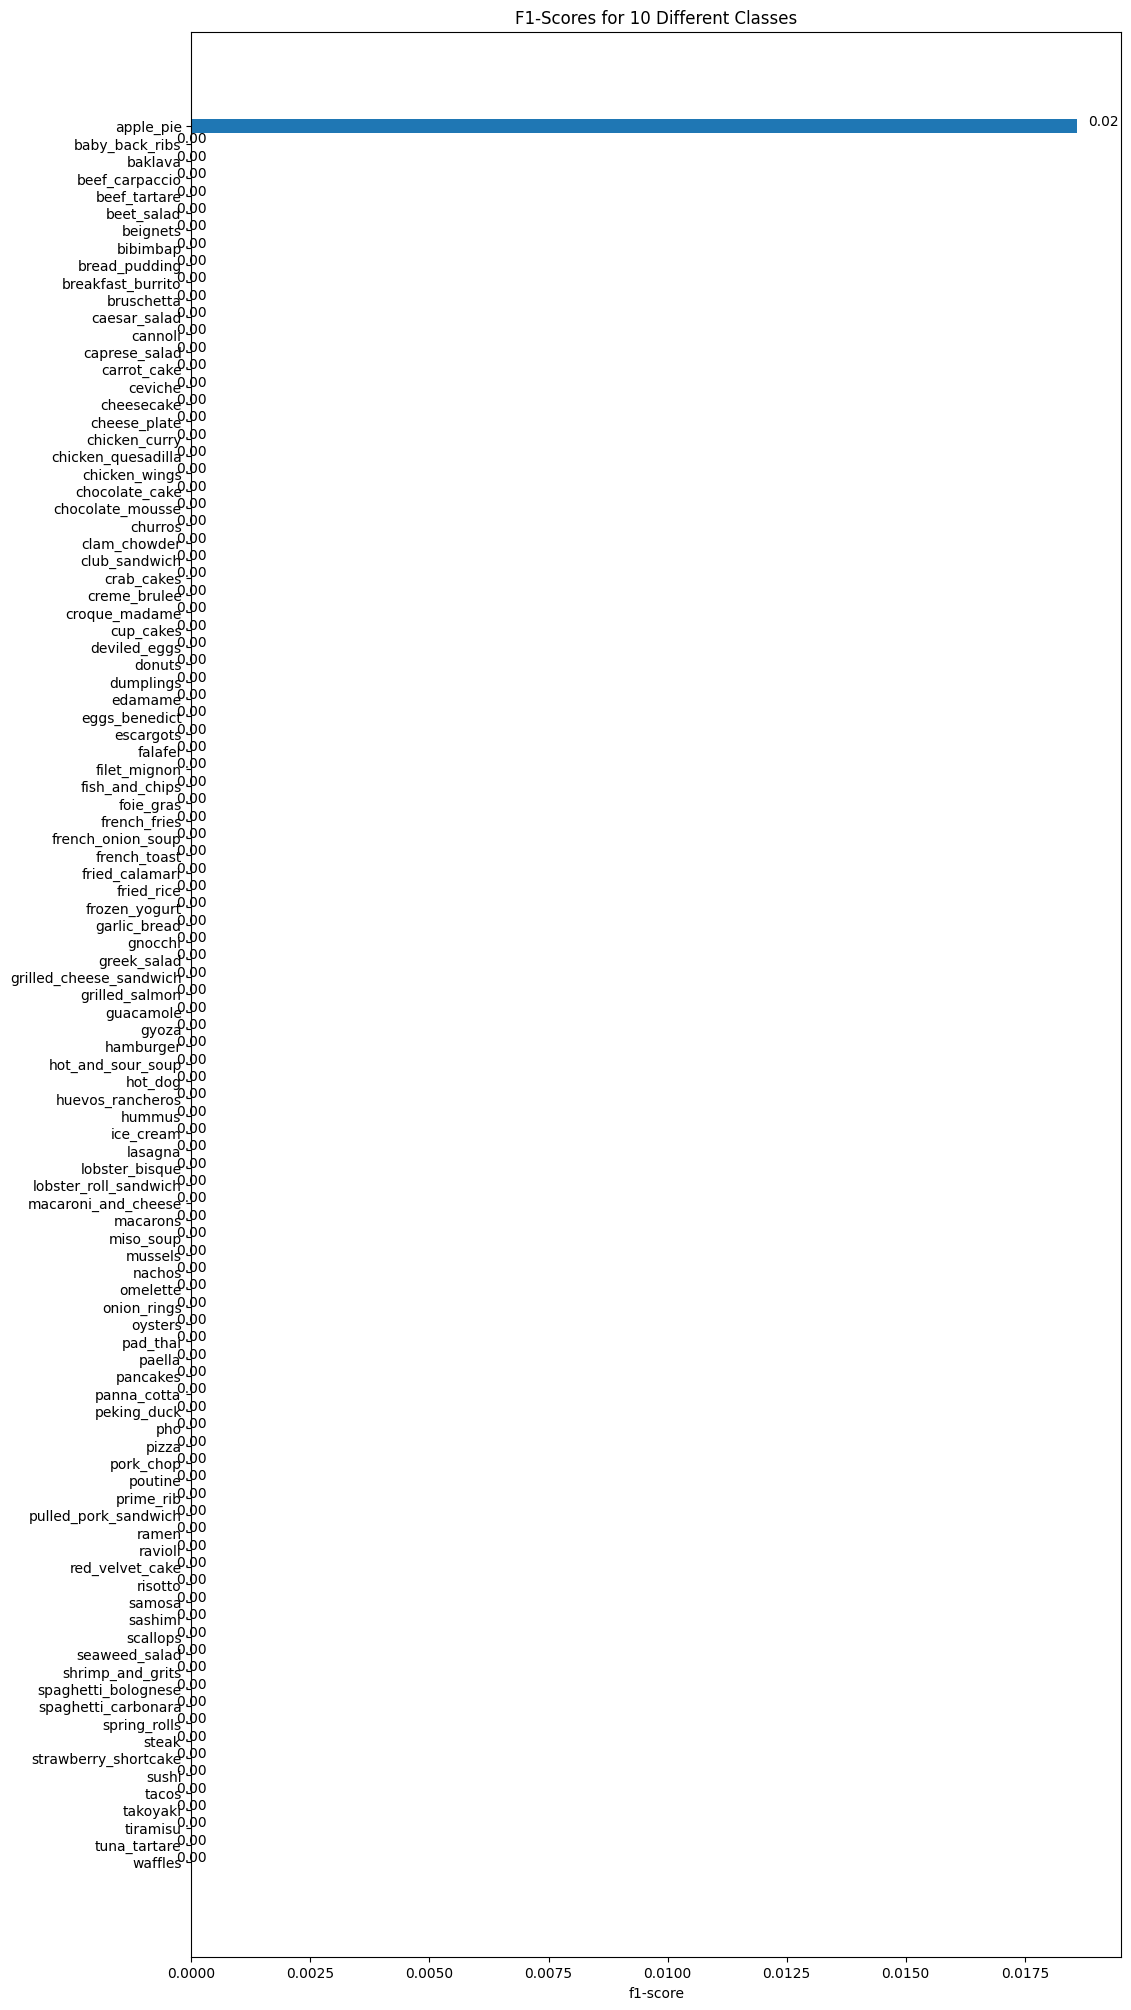

In [54]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)